In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools

In [2]:
framework = [
    "pandas",
    "spark",
    "vaex",
    "polars",
    "modin_dask",
    "modin_ray",
    "spark",
    "datatable",
    "pyspark_pandas",
]
datasets = ["test"] # INSERT THE DATASET NAME

conf_cpu = [1] # INSERT THE NUMBER OF CPU CORES (LOOK AT THE FOLDER NAME IN RESULTS)
conf_mem = [6] # INSERT THE AMOUNT OF MEMORY (LOOK AT THE FOLDER NAME IN RESULTS)

datasets_size = {
    "athlete": 0.0396,
}

In [3]:

def concatenate_csv(path, niter):
    """given a path, it returns a dataframe with the last niter csv files

    Args:
        path (str): path of the folder
        niter (int, optional): number of csv files to concatenate. Defaults to 3.

    Returns:
        DataFrame: dataframe with the last niter csv files
    """
    all_files = os.listdir(path)
    csv_files = [file for file in all_files if file.endswith('.csv')]
    csv_files = sorted(csv_files, key=lambda x: os.path.getmtime(os.path.join(path, x)), reverse=True)[:3]
    dfs = [pd.read_csv(os.path.join(path, file)) for file in csv_files]
    return pd.concat(dfs)


def get_dataframe_avg_time(framework, datasets, pipe, step, niter=3):
    """given a dataframe, it returns a dataframe with the average time for each algorithm method

    Args:
        df (DataFrame): dataframe with the time for each algorithm
        framework (str): framework name
        dataset (str): dataset name
        pipe (bool): if the dataframe is for the pipeline
        step (bool): if the dataframe is for the pipeline step

    Returns:
        DataFrame: dataframe with the average time for each algorithm
    """
    
    avg_time_cpu = pd.DataFrame(columns=["dataset", "size", "framework", "method", "cpu", "mem", "avg_time", "avg_memory"])
    
    for f, (d, size) in itertools.product(framework, datasets.items()):
        for cpu, mem in itertools.product(conf_cpu, conf_mem):
            d_name = d
            if step:
                d_name = f"{d}_pipe_step"
            elif pipe:
                d_name = f"{d}_pipe"
                
            path = f"./results/{d_name}/{f}_mem{mem}_cpu{cpu}/"
            # try to concatenate the last niter csv files if there is an error, it means that the algorithm is out of memory
            df = pd.DataFrame() # commodity dataframe for concatenation of csv files
            out_of_memory = {}
            try:
                df = concatenate_csv(path, niter)
            except Exception as e:
                print(f"Out of memory {f} {d}")
                out_of_memory[f, d] = 1
                continue
            
            # for each method, it calculates the average time and memory
            for m in df['method'].unique():
                # insert the row in the dataframe
                avg_time_cpu.loc[len(avg_time_cpu)] = [d, size, f, m, cpu, mem, df[df["method"] == m]['time'].mean(), df[df["method"] == m]['ram'].mean()]
            
    for k, v in out_of_memory.items():
        methods = avg_time_cpu.loc[(avg_time_cpu['dataset'] == k[1]) & (avg_time_cpu['framework'] == k[0])]['method'].unique()
        for m in methods:
            row_to_add = [k[1], datasets[k[1]], k[0], m, 0, 0, 0, 0]
            print(row_to_add)
            avg_time_cpu.loc[len(avg_time_cpu)] = [k[1], datasets[k[1]], k[0], m, 0, 0, 0, 0]
        
        #avg_time_cpu.loc[len(avg_time_cpu)] = [k[1], datasets[k[1]], k[0], "out_of_memory", 0, 0, 0, 0]        

            
    return avg_time_cpu

# open json file create a dataframe with indicates the key and the number of elements for each key
import json

def count_methods(df): 
    count = {}
    for d in df['dataset'].unique():
        print(d)
        # get file that end with _pipe.json
        file_name = [f for f in os.listdir(f"./datasets/{d}/") if "_pipe" in f][0]
        print(file_name)
        
        file = json.load(open(f"./datasets/{d}/{file_name}"))
        #for every key count the number of "method"
        count[d] = {}
        for k, e in file.items():
            # print unique methods
            for c in e:
                if c["method"] not in count:
                    if c["method"] == "force_execution":
                        continue
                    if k in ["Input", "output"]:
                        k = "i/o"
                    if k == "EDA":
                        k = "eda"
                    count[d][k, c['method']] = 1
    # count the number of methods for each key
    count_keys = {}
    for c in count:
        print(c)
        count_keys[c] = {}
        for k in count[c].keys():
            if k[0] not in count_keys[c]:
                count_keys[c][k[0]] = 1
            else:
                count_keys[c][k[0]] += 1
    json.dump(count_keys, open("count_keys.json", "w"))
    for d in df['dataset'].unique():
        for k in df[df['dataset'] == d]['method'].unique():
            print(d, k)
            df.loc[(df['dataset'] == d) & (df['method'] == k), 'count'] = count_keys[d][k]
    return df

def normalize_time_memory(df):
    df = count_methods(df)
    # normlize avg_time and avg_memory
    
    # calculate the tot method for every dataset
    values = df.groupby(['dataset', 'framework'])['count'].sum().reset_index()
    # map the value of the tot method for every dataset in the dataframe
    df['totm'] = df.apply(lambda x: values[(values['dataset'] == x['dataset']) & (values['framework'] == x['framework'])]['count'].values[0], axis=1)
    
    df['norm_avg_time'] = df['avg_time'] / df['totm']
    df['norm_avg_memory'] = df['avg_memory'] / df['totm']

    return df

def aggregate_core(df):
    for d in df['dataset'].unique():
        print(d)
        # get file that end with _pipe.json
        file_name = [f for f in os.listdir(f"./datasets/{d}/") if "_pipe" in f][0]
        print(file_name)
        
        file = json.load(open(f"./datasets/{d}/{file_name}"))
        
        # map each method to the step
        
        


In [5]:
df_core = get_dataframe_avg_time(framework, datasets_size, False, False, niter=1)
df_core.head()

,dataset,size,framework,method,cpu,mem,avg_time,avg_memory
0,athlete,0.0396,pandas,load_dataset,1,6,0.641866,0.0
1,athlete,0.0396,pandas,get_columns,1,6,0.000470,0.0
2,athlete,0.0396,pandas,locate_null_values,1,6,0.322707,0.0
3,athlete,0.0396,pandas,sort,1,6,0.060824,0.0
4,athlete,0.0396,pandas,query,1,6,0.039628,0.0


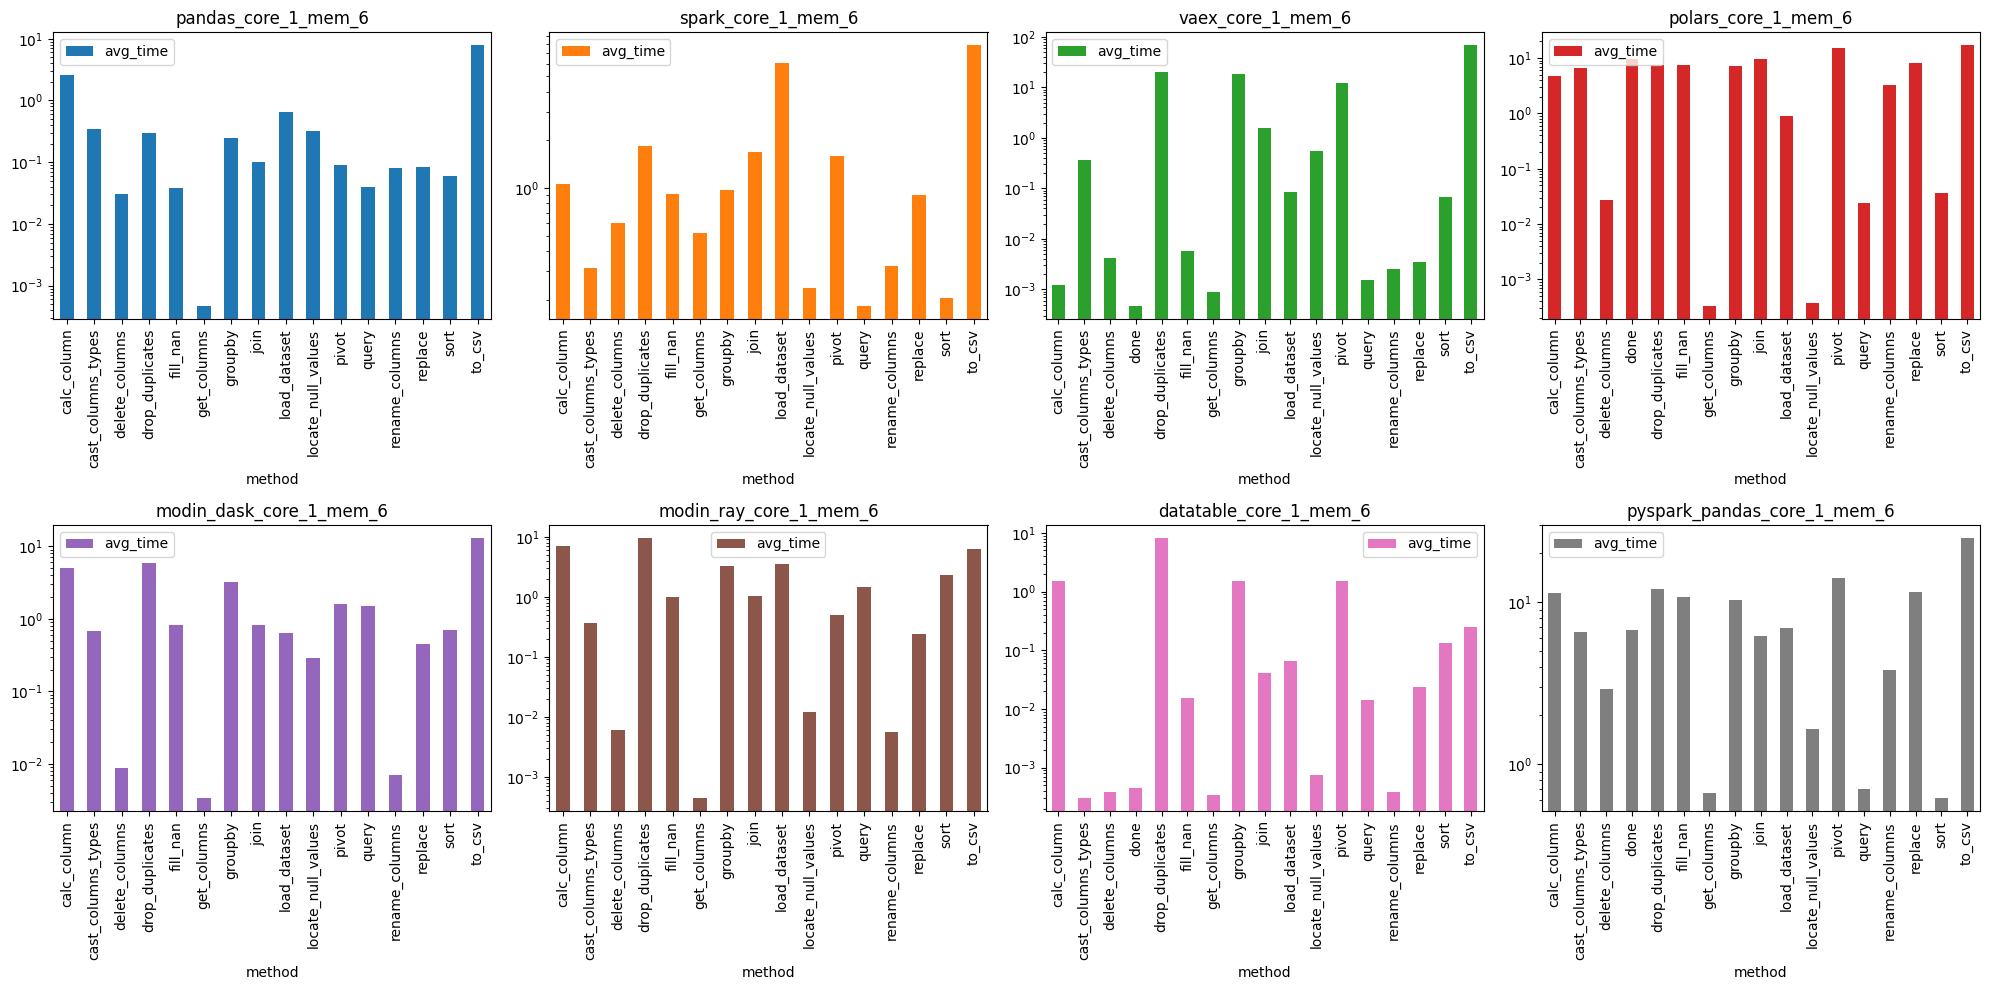

In [6]:
for d in df_core["dataset"].unique():
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

    # set a color for each axes
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
    ]

    for f, a in zip(df_core["framework"].unique(), ax.flatten()):
        df_core[df_core["framework"] == f].groupby(["dataset", "method"])[
            "avg_time"
        ].mean().reset_index().plot.bar(
            x="method",
            y="avg_time",
            rot=90,
            figsize=(20, 10),
            logy=True,
            ax=a,
            color=colors.pop(0),
        )
        a.set_title(f"{f}_core_{conf_cpu[0]}_mem_{conf_mem[0]}")
        # create a folder plots if not exists and save the figure

    os.makedirs(f"./plots/{d}/", exist_ok=True)

    fig.tight_layout()
    fig.savefig(f"./plots/{d}/{d}_core_{conf_cpu[0]}_mem_{conf_mem[0]}.png")

In [7]:
df_step = get_dataframe_avg_time(framework, datasets_size, False, True, niter=1)
df_step.head()

,dataset,size,framework,method,cpu,mem,avg_time,avg_memory
0,athlete,0.0396,pandas,Input,1,6,0.709997,0.0
1,athlete,0.0396,pandas,EDA,1,6,0.484425,0.0
2,athlete,0.0396,pandas,data_transformation,1,6,8.343994,0.0
3,athlete,0.0396,pandas,data_cleaning,1,6,0.475518,0.0
4,athlete,0.0396,pandas,output,1,6,1.890860,0.0


In [8]:
# merge Input and Output in I/O
df_step.loc[df_step['method'] == 'Input', 'method'] = 'i/o'
df_step.loc[df_step['method'] == 'output', 'method'] = 'i/o'
# sum the time for each method
df_step = df_step.groupby(['dataset', 'framework', 'method'])['avg_time'].sum().reset_index()

In [9]:
map_method = {
    "EDA": "EDA",
    "data_cleaning": "DC",
    "data_transformation": "DT",
    "i/o": "I/O",
}

df_step["method"] = df_step["method"].map(map_method)
df_step.head()

,dataset,framework,method,avg_time
0,athlete,datatable,EDA,0.107714
1,athlete,datatable,DC,2.781469
2,athlete,datatable,DT,6.920470
3,athlete,datatable,I/O,0.436923
4,athlete,modin_dask,EDA,2.090936


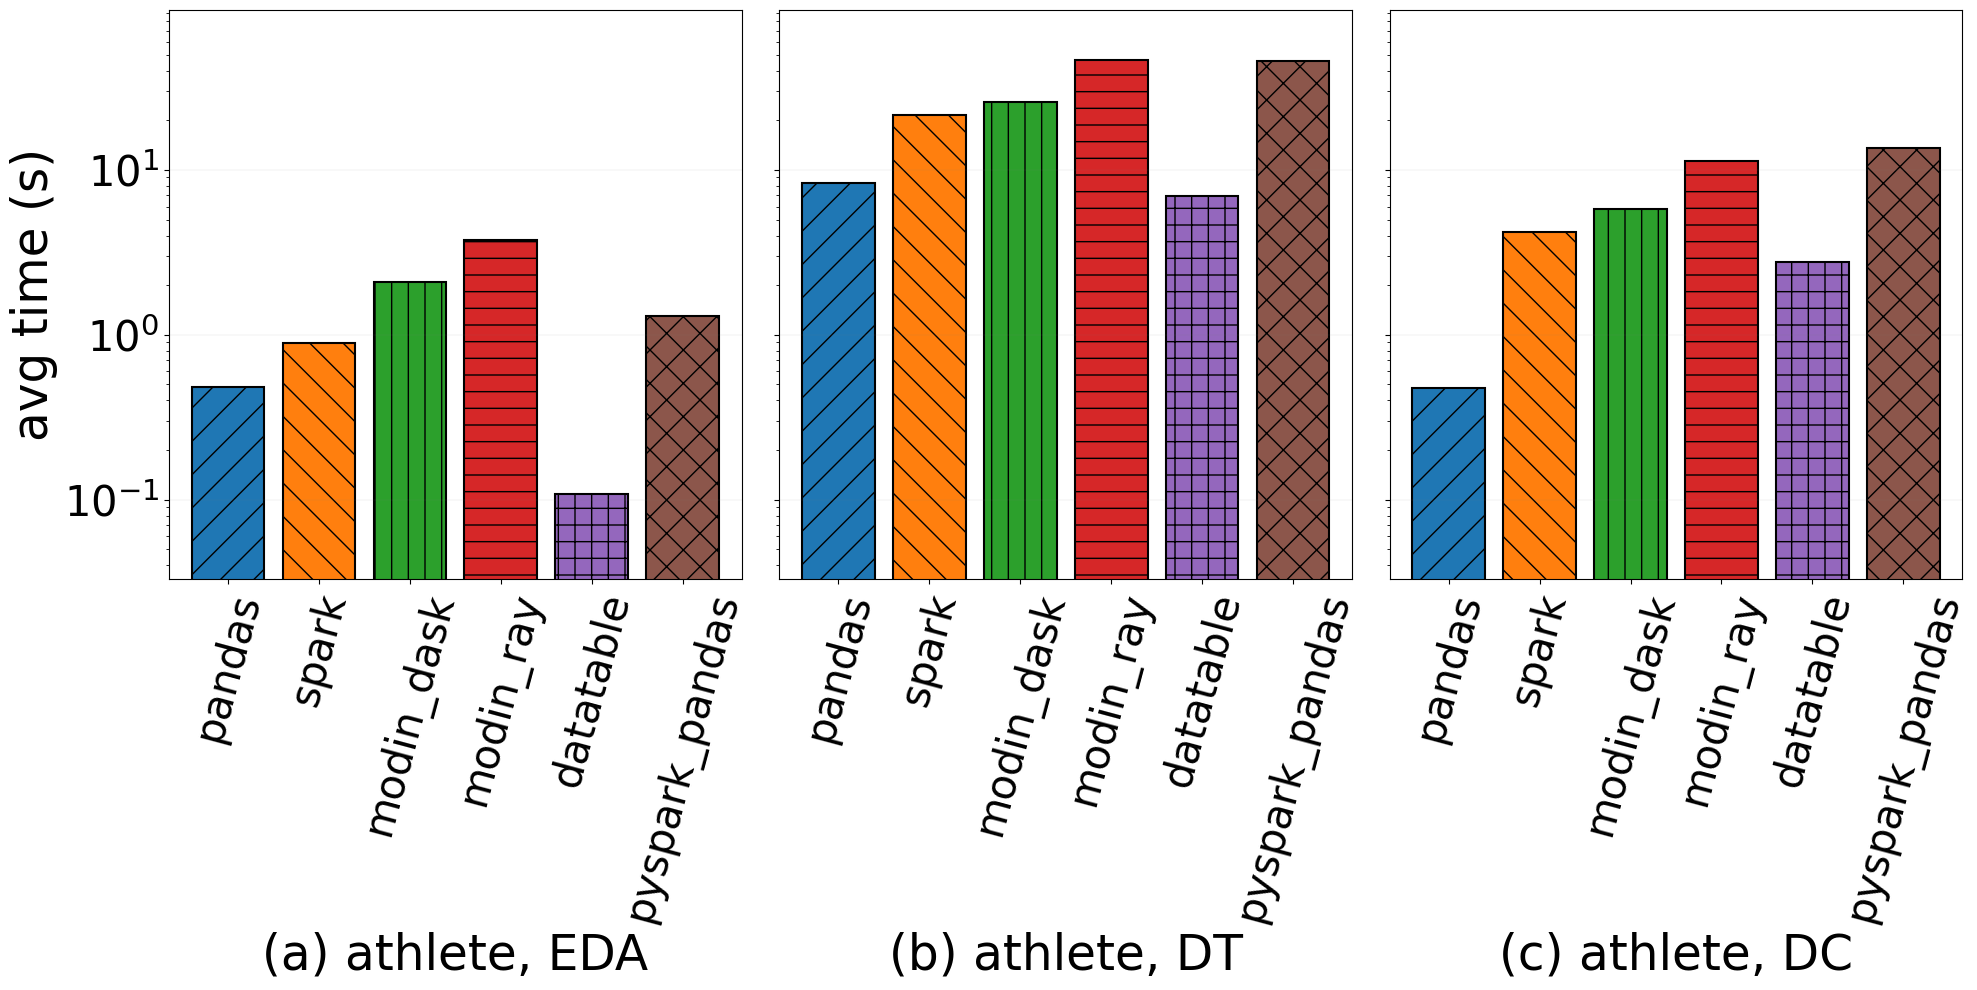

In [12]:
fig, axes = plt.subplots(
    nrows=len(df_step["dataset"].unique()), ncols=3, figsize=(20, 10), sharey=True
)
step = df_step.copy(deep=True)

y_min = step[step["avg_time"] > 0]["avg_time"].min() * 0.5
y_max = step[step["avg_time"] > 0]["avg_time"].max() * 1.8

order = ["pandas", "spark", "modin_dask", "modin_ray", "datatable", "pyspark_pandas"]
# colors for frameworks
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]

# associate color to order
color_order = dict(zip(order, colors))


# letter in range axes
letters = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"]

for (s, d), i in zip(
    itertools.product(["EDA", "DT", "DC"], datasets), enumerate(axes.flatten())
):
    n = i[0]
    ax = i[1]
    l = letters[n]

    tmp = step[(step["dataset"] == d) & (step["method"] == s)]
    tmp = tmp.pivot(index="framework", columns="method", values="avg_time")
    tmp = tmp.reindex(order)

    pl = tmp.plot.bar(
        legend=False,
        rot=75,
        logy=True,
        linewidth=1.5,
        edgecolor="black",
        ax=ax,
        width=0.8,
        ylim=(y_min, y_max),
    )
    # add subplot label letter dataset and method
    ax.set_xlabel(f"({l}) {d}, {s}", fontsize=35)

    xticklabels = ax.get_xticklabels()
    hatch = ["/", "\\", "|", "-", "+", "x", "o", "O", ".", "*"]
    for b in ax.containers:
        for i, p in enumerate(b.patches):
            # set color on the base of the framework
            # get xtik label
            xticklabel = xticklabels[i].get_text()
            p.set_color(color_order[xticklabel])
    for bars in pl.patches:
        bars.set_edgecolor("black")
        bars.set_hatch(hatch.pop(0))

    # add red cross if the height is 0
    for p in ax.patches:
        if p.get_height() == 0:
            ax.text(
                p.get_x() + p.get_width() / 2 - 0.26,
                1.9,
                "out of mem",
                rotation=90,
                color="red",
                fontsize=25,
                va="center",
                weight="bold",
                fontname="Times New Roman",
            )

    # set grid
    ax.grid(axis="y", linestyle="-", alpha=0.25, linewidth=0.3, color="grey")

    # if dataset is Taxi remove all 0 xticks

    # set y label
    ax.set_ylabel("avg time (s)", fontsize=35)

    # set size of xticks
    ax.tick_params(axis="x", which="major", labelsize=30)
    ax.tick_params(axis="y", which="major", labelsize=30)

fig.tight_layout()
fig.savefig(f"./plots/step_{conf_cpu[0]}_mem_{conf_mem[0]}.png")

In [22]:
df_core = get_dataframe_avg_time(framework, datasets_size, False, False, niter=1)
df_step = get_dataframe_avg_time(framework, datasets_size, False, True, niter=1)
df_pipe = get_dataframe_avg_time(framework, datasets_size, True, False, niter=1)

In [23]:
for d in df_core["dataset"].unique():
    # get file that end with _pipe.json
    file_name = [f for f in os.listdir(f"./datasets/{d}/") if "_pipe" in f][0]

    file = json.load(open(f"./datasets/{d}/{file_name}"))

    # map each method to the step
    for k, e in file.items():
        for c in e:
            df_core.loc[
                (df_core["dataset"] == d) & (df_core["method"] == c["method"]), "step"
            ] = k

In [24]:
# drop rows with NaN values
df_core = df_core.dropna()

In [25]:
core = df_core.groupby(['dataset', 'framework', 'step'])['avg_time'].sum().reset_index()

In [26]:
# change column name from step to method
core = core.rename(columns={'step': 'method'})
core.head()

,dataset,framework,method,avg_time
0,athlete,datatable,EDA,0.148201
1,athlete,datatable,Input,0.065750
2,athlete,datatable,data_cleaning,8.242690
3,athlete,datatable,data_transformation,4.530487
4,athlete,datatable,output,0.248673


In [27]:
# add type column
core['type'] = 'core'
df_step['type'] = 'step'
df_pipe['type'] = 'pipe'

In [28]:
df_merged = pd.concat([core, df_step, df_pipe], axis=0)
df_merged = df_merged[['dataset', 'framework', 'method', 'type', 'avg_time']]
df_merged.head()

,dataset,framework,method,type,avg_time
0,athlete,datatable,EDA,core,0.148201
1,athlete,datatable,Input,core,0.065750
2,athlete,datatable,data_cleaning,core,8.242690
3,athlete,datatable,data_transformation,core,4.530487
4,athlete,datatable,output,core,0.248673


In [29]:
df_merged.groupby(['dataset', 'framework', 'type'])['avg_time'].sum().reset_index()

,dataset,framework,type,avg_time
0,athlete,datatable,core,13.235801
1,athlete,datatable,pipe,22.261599
2,athlete,datatable,step,10.246576
3,athlete,modin_dask,core,34.595572
4,athlete,modin_dask,pipe,63.397838
5,athlete,modin_dask,step,38.880013
6,athlete,modin_ray,core,36.418727
7,athlete,modin_ray,pipe,70.983515
8,athlete,modin_ray,step,69.449994
9,athlete,pandas,core,12.742206


In [30]:
# set the order of type to core, step, pipe
df_merged['type'] = pd.Categorical(df_merged['type'], ['core', 'step', 'pipe'])
df_merged = df_merged.sort_values('type')
df_merged.head()

,dataset,framework,method,type,avg_time
0,athlete,datatable,EDA,core,0.148201
22,athlete,polars,data_cleaning,core,23.134006
23,athlete,polars,data_transformation,core,46.872202
24,athlete,polars,output,core,16.950448
25,athlete,pyspark_pandas,EDA,core,3.636433


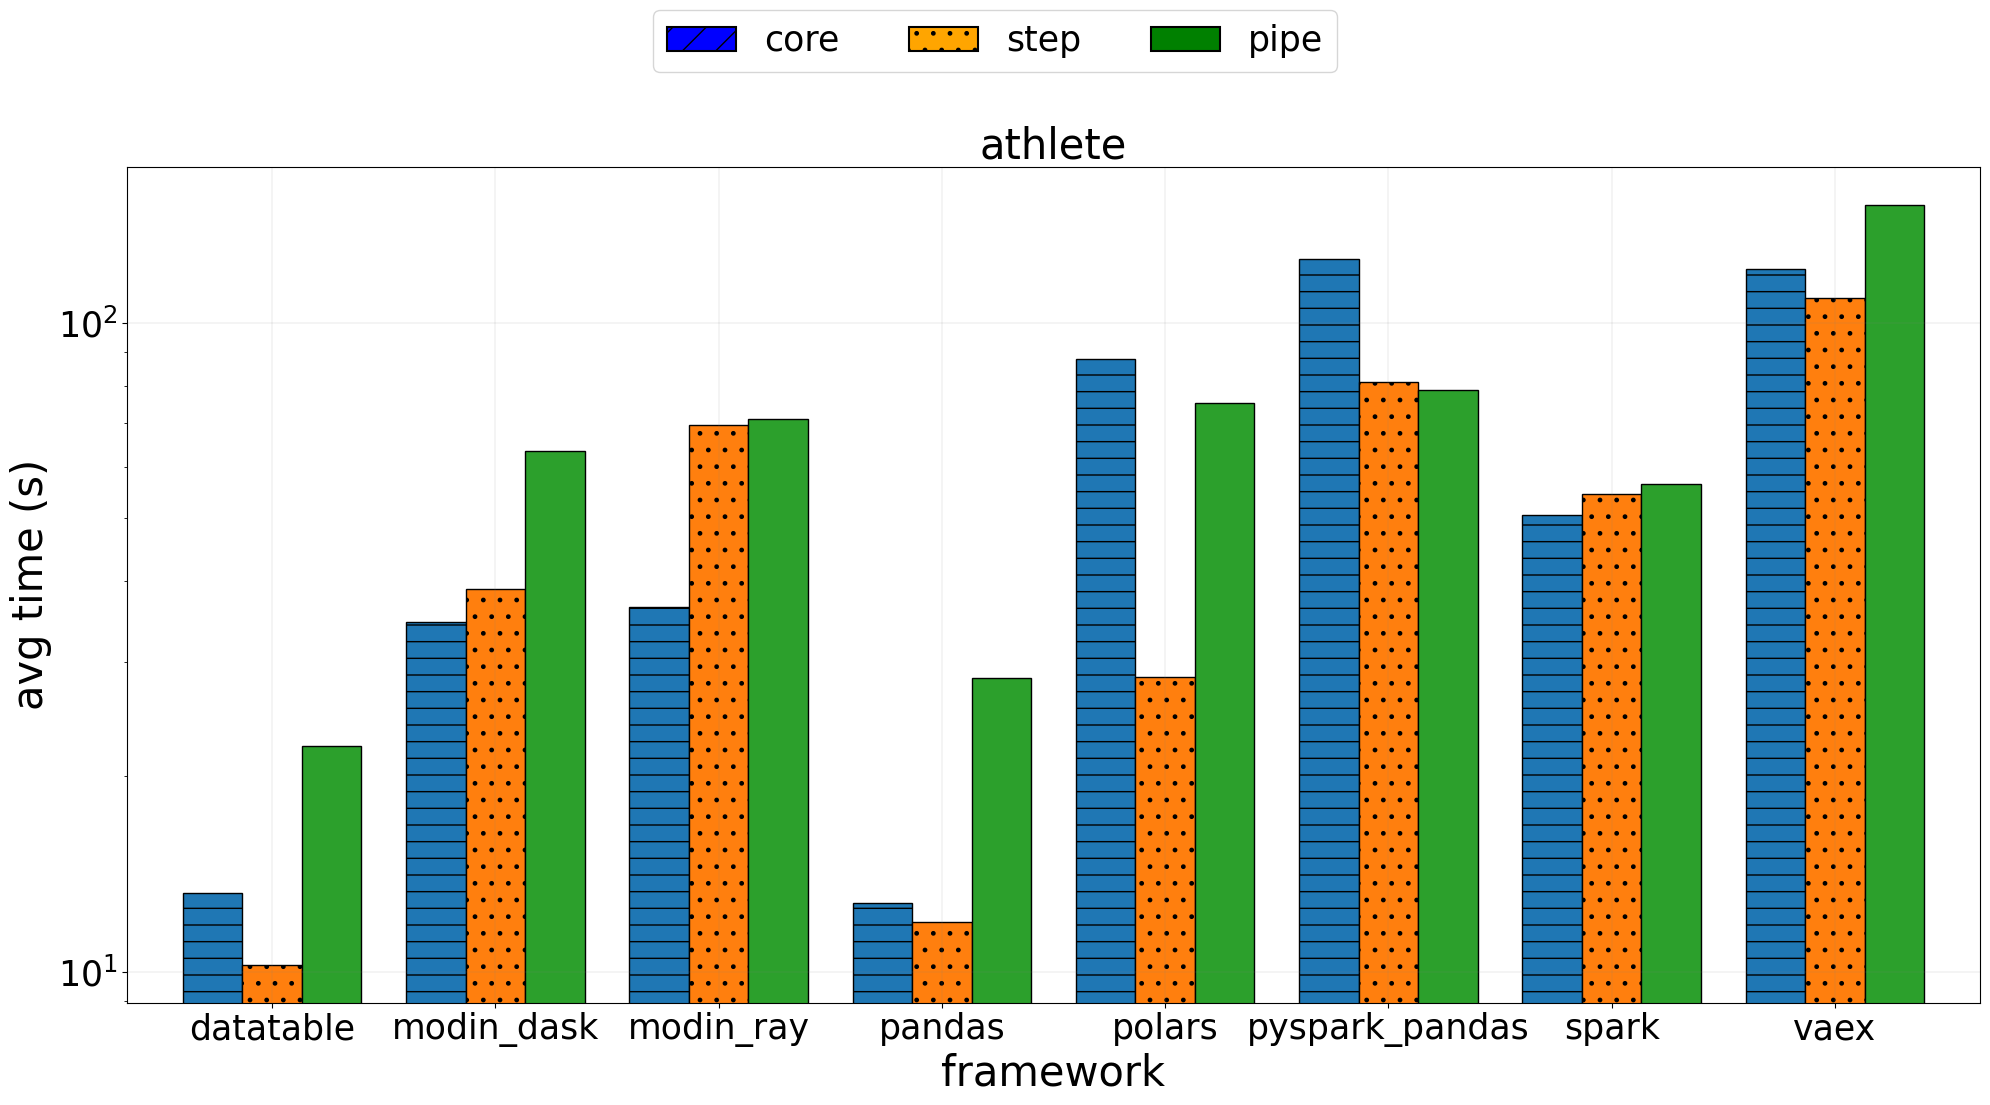

In [31]:
hatch_type = {"core": "/", "step": ".", "pipe": ""}


for d in df_merged["dataset"].unique():
    filtered = df_merged[df_merged["dataset"] == d]
    fig, ax = plt.subplots(figsize=(20, 10))
    filtered.groupby(["framework", "type"])["avg_time"].sum().reset_index().pivot(
        index="framework", columns="type", values="avg_time"
    ).plot.bar(
        legend=False,
        rot=0,
        logy=True,
        linewidth=1,
        edgecolor="black",
        title=d,
        width=0.8,
        ax=ax,
    )

    bars = ax.patches
    hatches = "".join(h * len(df_merged["framework"].unique()) for h in ["-", ".", ""])
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    # set grid
    ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)

    # sdet font size
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.set_title(d, fontsize=30)
    # set font size for x and y label
    ax.set_xlabel("framework", fontsize=30)
    ax.set_ylabel("avg time (s)", fontsize=30)


# legend for the type
handles = []
labels = []
colors = ["b", "orange", "green"]
for t, h in hatch_type.items():
    handles.append(
        plt.Rectangle(
            (0, 0),
            1,
            1,
            hatch=h,
            edgecolor="black",
            linewidth=1.5,
            facecolor=colors.pop(0),
        )
    )
    labels.append(t)

# set legend on the top center
fig.legend(
    handles,
    labels,
    loc="upper center",
    fontsize=25,
    bbox_to_anchor=(0.5, 1.1),
    borderaxespad=0.0,
    fancybox=True,
    ncol=3,
)

fig.tight_layout()
fig.savefig(f"./plots/{d}/{d}_core_step_pipe_{conf_cpu[0]}_mem_{conf_mem[0]}.png")